In [57]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
import mir_eval
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers import concatenate as concat

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


def data_genlist(audio_data, n_detect, nsp_excerpt, type_excerpt, hop_length=HOP_LENGTH):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    src_batchs = []
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    for i in range(n_detect):

        if type_excerpt == 'onset':
            src_batch = audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)]
        elif type_excerpt == 'segment':
            src_batch = np.tile(audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)],tile_times)[:NSP_SRC]
            
        src_batchs.append(src_batch)
        
    return src_batchs            

def intervals1tointervals01(segintervals1, paudio_duration):
    idx2del = []
    for idx in np.arange(1,len(segintervals1)):
        if segintervals1[idx-1][1] >= segintervals1[idx][0]:
            segintervals1[idx] = [segintervals1[idx-1][0],segintervals1[idx][1]]
            idx2del.append(idx-1)           
    segintervals1 = np.delete(segintervals1, idx2del, axis=0)  
    
    labels = []
    segintervals01 = np.zeros((len(segintervals1)*2+1,2))
    
    for idx in range(len(segintervals01)):
        if idx==0:
            segintervals01[idx] = [0, segintervals1[0][0]]
            labels.append('np')
        elif idx==len(segintervals01)-1:
            segintervals01[idx] = [segintervals1[-1][-1],paudio_duration]
            labels.append('np')
        elif idx%2:
            segintervals01[idx] = segintervals1[int(np.floor(idx/2))]
            labels.append('p')
        else:
            segintervals01[idx] = [segintervals1[int(np.floor(idx/2)-1)][-1],segintervals1[int(np.floor(idx/2))][0]]
            labels.append('np')
            
    idx2del = []
    for idx, seginterval in enumerate(segintervals01):
        if seginterval[0]==seginterval[1]:
            idx2del.append(idx)
    segintervals01 = np.delete(segintervals01, idx2del, axis=0)
    labels = np.delete(labels, idx2del)
    
    return segintervals1, segintervals01, labels


def model_convkernel_melspectrogram(n_freq, n_time, n_out, inputshape, out_activation='softmax'):
    """
    A simple conv2D model using mel spectrogram as input.
    """

    audio_input = Input(shape=inputshape)
    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, 
                       return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)
    
    x1 = Conv2D(7, (n_freq[0], n_time[0]), padding='same')(x)
    x2 = Conv2D(7, (n_freq[1], n_time[1]), padding='same')(x)
    x3 = Conv2D(7, (n_freq[2], n_time[2]), padding='same')(x)
    x = Concatenate(axis=channel_axis)([x1, x2, x3])
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(21, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(21, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(21, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation)(x)

    model = Model(audio_input, out)

    return model

In [2]:
dataset_type = 'segment'
input_type = 'melspectrogram'
typeshape = SEGMENT_INPUT_SHAPE
n_freqs = [45,3,3]
n_times = [3,3,10]
        
model_name = 'cnnkernel-{}'.format(input_type)
exp_name = 'sub-{}_{}_multift'.format(dataset_type, model_name)
segment_model = model_convkernel_melspectrogram(n_freq=n_freqs, n_time=n_times, n_out=2, inputshape=typeshape)
segment_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(exp_name)))
# get model summary
segment_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 88200)     0                                            
__________________________________________________________________________________________________
melspectrogram_1 (Melspectrogra (None, 128, 200, 1)  1116288     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 200, 1)  4           melspectrogram_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 200, 7)  952         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
bottleneck_input  = segment_model.get_layer(index=0).input
bottleneck_output = segment_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

for layer in bottleneck_model.layers:
    layer.trainable = False

In [19]:
npz_dir = os.path.join(DIR_REAL_DATA, 'reference') 
dataset_name = 'pedal-times_realaudio.npz'
npz_path = os.path.join(npz_dir, dataset_name)

tracks = np.load(npz_path)
filenames = tracks['filename']
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']

# for filename_idx, filename in enumerate(filenames):  
#     pedal_offset_gt = np.array(pedal_offset_gt_tracks[filename_idx])
#     pedal_onset_gt = np.array(pedal_onset_gt_tracks[filename_idx])

#     paudio_dir = os.path.join(DIR_REAL_DATA, '{}'.format(filename)) 
#     paudio_path = os.path.join(paudio_dir, '{}.wav'.format(filename))

#     paudio, sr = librosa.load(paudio_path, sr=SR) 
#     print("{}...".format(filename))
#     len_segment_shape = int(SR * MIN_SRC)
#     seghop_length = HOP_LENGTH*10
#     seghop_duration = seghop_length/SR
#     n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
#     data_psegment = data_genlist(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)

#     # set the ground truth frame by frame
#     paudio_duration = librosa.get_duration(y=paudio, sr=SR)
#     n_frames = int(np.ceil(paudio_duration/seghop_duration))
#     segframes_gt = np.zeros(n_frames)

#     pedal_offset_gt = np.array(tracks['pedal_offset'][filename_idx])
#     pedal_onset_gt = np.array(tracks['pedal_onset'][filename_idx])
#     longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
#     longseg_onset_gt = pedal_onset_gt[longpseg_idx]
#     longseg_offset_gt = pedal_offset_gt[longpseg_idx]
#     segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

#     for idx, onset_t in enumerate(longseg_onset_gt):
#         offset_t = longseg_offset_gt[idx]
#         onset_frm = int(onset_t//seghop_duration)
#         offset_frm = int(offset_t//seghop_duration)
#         segframes_gt[onset_frm:offset_frm] = 1   

#     # align the segframes_gt to the features from transfer learning
#     segframes_gt_transfer = segframes_gt[1:1+n_psegment]
#     group = np.array([filename] * n_psegment)

#     # concat
#     if filename_idx == 0:
#         segment_datas = np.copy(data_psegment)
#         segframes_gt_transfers = np.copy(segframes_gt_transfer)
#         groups = np.copy(group)
#     else:
#         segment_datas = np.concatenate((segment_datas, data_psegment),axis=0)
#         segframes_gt_transfers = np.concatenate((segframes_gt_transfers, segframes_gt_transfer),axis=0)
#         groups = np.concatenate((groups, group),axis=0)

# save_dir = os.path.join(DIR_REAL_DATA, 'reference')                            
# np.savez(os.path.join(save_dir, 'transfer-learning-dyg_segment.npz'), 
#          d=segment_datas, y=segframes_gt_transfers, groups=groups)

ChopinOp66...
ChopinOp28No20...
ChopinOp10No3...
ChopinB49...
ChopinOp28No15...
ChopinOp28No4...
ChopinOp28No7...
ChopinOp23No1...
ChopinOp28No6...
ChopinOp69No2...


In [20]:
save_dir = os.path.join(DIR_REAL_DATA, 'reference')
xyg = np.load(os.path.join(save_dir, 'transfer-learning-dyg_segment.npz'))
d = xyg['d']
y = xyg['y']
groups = xyg['groups']

In [32]:
reg_w = 1e-4
epochs = 50
patience = 10
batch_size = 1

def data_gen(dataset_type, df_subset, ys, is_shuffle, batch_size=20):
    """Data generator.
    dataset_type: onset or segment
    df_subset: pandas dataframe, with rows subset
    ys: numpy arrays, N-by-8 one-hot-encoded labels
    is_shuffle: shuffle every batch if True.
    batch_size: integer, size of batch. len(df_subset) % batch_size should be 0.
    """
    if dataset_type == "onset":
        dir_pedal_npy = DIR_PEDAL_ONSET_NPY
    elif dataset_type == "segment":
        dir_pedal_npy = DIR_PEDAL_SEGMENT_NPY
    else:
        print("ERROR: dataset type must be either onset or segment!")
        
    n_data = len(df_subset)
    n_batch = n_data // batch_size

    while True:
        for batch_i in range(n_batch):
            if is_shuffle:
                batch_idxs = np.random.choice(n_data, batch_size, replace=False)
            else:
                batch_idxs = range(batch_i * batch_size, (batch_i + 1) * batch_size)

            src_batch = np.array([df_subset[i] for i in batch_idxs], dtype=K.floatx())
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible

            y_batch = np.array([ys[i] for i in batch_idxs], dtype=K.floatx())
            
            yield src_batch, y_batch
        
        
def get_callbacks(name,patience,dir_save_finetune):   
        
    early_stopper = keras.callbacks.EarlyStopping(patience=patience)
    model_saver = keras.callbacks.ModelCheckpoint(os.path.join(dir_save_finetune,"{}_best_model.h5".format(name)),
                                                  save_best_only=True)
    weight_saver = keras.callbacks.ModelCheckpoint(os.path.join(dir_save_finetune,"{}_best_weights.h5".format(name)),
                                                   save_best_only=True,
                                                   save_weights_only=True)
    csv_logger = keras.callbacks.CSVLogger(os.path.join(dir_save_finetune,"{}.log".format(name)))
    return [early_stopper, model_saver, weight_saver, csv_logger]

In [53]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dir_save_finetune = os.path.join(DIR_REAL_DATA,"finetune-model")
if not os.path.exists(dir_save_finetune):
    os.makedirs(dir_save_finetune) 
        
group_kfold = GroupKFold(n_splits=10)

filename_records = []
support0s, support1s = [], []
p1_frms, r1_frms, f1_frms = [], [], []
y_trues, y_preds = [], []
for train_index, test_index in group_kfold.split(d, y, groups):
    print("TEST:", np.unique(groups[test_index]))
    X_train, X_test = d[train_index], d[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_train = keras.utils.to_categorical(y_train, 2)
    y_test = keras.utils.to_categorical(y_test, 2)

    # preparing data generators
    steps_per_epoch = len(y_train) // 128
    gen_train = data_gen(dataset_type, X_train, y_train, True, batch_size=128)
    gen_test = data_gen(dataset_type, X_test, y_test, False, batch_size=1)
       
    model_name = 'cnnkernel-{}'.format(input_type)
    exp_name = '{}-{}_{}_multift'.format(np.unique(groups[test_index])[0], dataset_type, model_name)
    
    # callbacks
    callbacks = get_callbacks(exp_name, patience, dir_save_finetune)
    early_stopper, model_saver, weight_saver, csv_logger = callbacks
    
    print("Starting to train...")
    n_channel = 21
    new_model = Sequential()
    new_model.add(bottleneck_model)
    new_model.add(Dense(2, activation='softmax', input_dim=n_channel))

    new_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    new_model.fit_generator(gen_train, steps_per_epoch, epochs=epochs,
                            callbacks=callbacks,
                            validation_data=gen_test,
                            validation_steps=len(y_test) // 1)

    print("Training is done. Loading the best weights...")
    new_model.load_weights(os.path.join(dir_save_finetune,"{}_best_weights.h5".format(exp_name)))

    print("Evaluating...")
    y_pred = new_model.predict_generator(gen_test, len(y_test) // 1)  
    y_pred_binary = np.zeros(len(y_pred), dtype=int)
    for i, j in enumerate(y_pred):
        if j[1]>j[0]:
            y_pred_binary[i] = 1
#     y_pred_binary = np.argmax(y_pred,axis=1)
    p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(y[test_index],y_pred_binary)
    
    
    print('  RESULT:')
    print('  - support 0 vs 1: {} vs {}'.format(support[0], support[1]))
    print('  - precision: {0:.4f}'.format(p1_frm[1]))
    print('  -    recall: {0:.4f}'.format(r1_frm[1]))
    print('  -  f1 score: {0:.4f}'.format(f1_frm[1]))
    filename_records.append(np.unique(groups[test_index])[0])
    support0s.append(support[0])
    support1s.append(support[1])
    p1_frms.append(p1_frm[1])
    r1_frms.append(r1_frm[1])
    f1_frms.append(f1_frm[1])
    y_trues.append(y[test_index])
    y_preds.append(y_pred_binary)

TEST: ['ChopinB49']
Starting to train...
Epoch 1/50
66/66 [==============================] - 12s 177ms/step - loss: 0.6426 - acc: 0.7467 - val_loss: 0.5810 - val_acc: 0.7249
Epoch 2/50
66/66 [==============================] - 11s 169ms/step - loss: 0.5164 - acc: 0.7545 - val_loss: 0.5803 - val_acc: 0.7332
Epoch 3/50
66/66 [==============================] - 11s 167ms/step - loss: 0.5235 - acc: 0.7547 - val_loss: 0.5816 - val_acc: 0.7345
Epoch 4/50
66/66 [==============================] - 11s 171ms/step - loss: 0.5057 - acc: 0.7700 - val_loss: 0.5799 - val_acc: 0.7371
Epoch 5/50
66/66 [==============================] - 11s 166ms/step - loss: 0.5112 - acc: 0.7633 - val_loss: 0.5791 - val_acc: 0.7390
Epoch 6/50
66/66 [==============================] - 11s 173ms/step - loss: 0.5065 - acc: 0.7634 - val_loss: 0.5803 - val_acc: 0.7423
Epoch 7/50
66/66 [==============================] - 11s 164ms/step - loss: 0.5081 - acc: 0.7629 - val_loss: 0.5795 - val_acc: 0.7410
Epoch 8/50
66/66 [==========

Epoch 11/50
70/70 [==============================] - 10s 147ms/step - loss: 0.5337 - acc: 0.7586 - val_loss: 0.6114 - val_acc: 0.7610
Epoch 12/50
70/70 [==============================] - 10s 138ms/step - loss: 0.5202 - acc: 0.7652 - val_loss: 0.6093 - val_acc: 0.7619
Epoch 13/50
70/70 [==============================] - 10s 138ms/step - loss: 0.5175 - acc: 0.7699 - val_loss: 0.6103 - val_acc: 0.7610
Training is done. Loading the best weights...
Evaluating...
  RESULT:
  - support 0 vs 1: 268 vs 849
  - precision: 0.7615
  -    recall: 0.9965
  -  f1 score: 0.8633
TEST: ['ChopinOp28No6']
Starting to train...
Epoch 1/50
70/70 [==============================] - 10s 148ms/step - loss: 0.6574 - acc: 0.7254 - val_loss: 0.6933 - val_acc: 0.5701
Epoch 2/50
70/70 [==============================] - 10s 138ms/step - loss: 0.5695 - acc: 0.7300 - val_loss: 0.6050 - val_acc: 0.7019
Epoch 3/50
70/70 [==============================] - 10s 138ms/step - loss: 0.5429 - acc: 0.7414 - val_loss: 0.5597 - val

72/72 [==============================] - 9s 121ms/step - loss: 0.5172 - acc: 0.7537 - val_loss: 0.5217 - val_acc: 0.8160
Epoch 9/50
72/72 [==============================] - 9s 121ms/step - loss: 0.5073 - acc: 0.7618 - val_loss: 0.5506 - val_acc: 0.7876
Epoch 10/50
72/72 [==============================] - 9s 121ms/step - loss: 0.5057 - acc: 0.7612 - val_loss: 0.5463 - val_acc: 0.7902
Epoch 11/50
72/72 [==============================] - 9s 122ms/step - loss: 0.4968 - acc: 0.7687 - val_loss: 0.5161 - val_acc: 0.8185
Epoch 12/50
72/72 [==============================] - 9s 121ms/step - loss: 0.4921 - acc: 0.7734 - val_loss: 0.5189 - val_acc: 0.8198
Epoch 13/50
72/72 [==============================] - 9s 120ms/step - loss: 0.4997 - acc: 0.7656 - val_loss: 0.5135 - val_acc: 0.8172
Training is done. Loading the best weights...
Evaluating...
  RESULT:
  - support 0 vs 1: 186 vs 591
  - precision: 0.7622
  -    recall: 0.9272
  -  f1 score: 0.8366
TEST: ['ChopinOp28No7']
Starting to train...
Epo

In [54]:
rows = zip(*[filename_records, support0s, support1s, p1_frms, r1_frms, f1_frms])
column_names =  ['filename_record', 'support0', 'support1', 'p1_frm', 'r1_frm', 'f1_frm']
df = pd.DataFrame(rows, columns = column_names)

save_dir = os.path.join(DIR_REAL_DATA, 'reference')
df.to_csv(os.path.join(save_dir, 'transfer-learning-finetune-result_segment.csv'))

np.savez(os.path.join(save_dir, 'transfer-learning-finetune-y_segment.npz'), 
         filename_record = filename_records, y_true = y_trues, y_pred = y_preds)

In [58]:
from sklearn.metrics import classification_report, f1_score

for filename, y_true, y_pred in zip(filename_records, y_trues, y_preds):
    print("* {}".format(filename))
    print(classification_report(y_true, y_pred, target_names=['w/o', 'pedal'], digits=4))
    tf_microf1 = f1_score(y_true, y_pred, average='micro')
    print("micro F1     {:9.4f}".format(tf_microf1))
    print("-"*60)

* ChopinB49
             precision    recall  f1-score   support

        w/o     0.2000    0.0522    0.0827       441
      pedal     0.7091    0.9172    0.7998      1111

avg / total     0.5645    0.6714    0.5961      1552

micro F1        0.6714
------------------------------------------------------------
* ChopinOp28No4
             precision    recall  f1-score   support

        w/o     0.2857    0.0373    0.0659       322
      pedal     0.7569    0.9698    0.8502       995

avg / total     0.6417    0.7418    0.6585      1317

micro F1        0.7418
------------------------------------------------------------
* ChopinOp10No3
             precision    recall  f1-score   support

        w/o     0.5000    0.0112    0.0219       268
      pedal     0.7615    0.9965    0.8633       849

avg / total     0.6987    0.7601    0.6614      1117

micro F1        0.7601
------------------------------------------------------------
* ChopinOp28No6
             precision    recall  f1-score 

In [59]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
        
group_kfold = GroupKFold(n_splits=10)

filename_records = []
support0s, support1s = [], []
p1_frms, r1_frms, f1_frms = [], [], []
y_trues, y_preds = [], []
for train_index, test_index in group_kfold.split(d, y, groups):
    print("TEST:", np.unique(groups[test_index]))
    X_train, X_test = d[train_index], d[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_train = keras.utils.to_categorical(y_train, 2)
    y_test = keras.utils.to_categorical(y_test, 2)

    # preparing data generators
    steps_per_epoch = len(y_train) // 128
    gen_train = data_gen(dataset_type, X_train, y_train, True, batch_size=128)
    gen_test = data_gen(dataset_type, X_test, y_test, False, batch_size=1)      
    
    dataset_type = 'segment'
    input_type == 'melspectrogram'
    typeshape = SEGMENT_INPUT_SHAPE
    n_freqs = [45,3,3]
    n_times = [3,3,10]

    model_name = 'cnnkernel-{}'.format(input_type)
    exp_name = 'sub-{}_{}_multift'.format(dataset_type, model_name)
    segment_model = model_convkernel_melspectrogram(n_freq=n_freqs, n_time=n_times, n_out=2, inputshape=typeshape)
    segment_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(exp_name)))

    print("Evaluating...")
    y_pred = new_model.predict_generator(gen_test, len(y_test) // 1)  
    y_pred_binary = np.zeros(len(y_pred), dtype=int)
    for i, j in enumerate(y_pred):
        if j[1]>j[0]:
            y_pred_binary[i] = 1
    p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(y[test_index],y_pred_binary)
    
    
    print('  RESULT:')
    print('  - support 0 vs 1: {} vs {}'.format(support[0], support[1]))
    print('  - precision: {0:.4f}'.format(p1_frm[1]))
    print('  -    recall: {0:.4f}'.format(r1_frm[1]))
    print('  -  f1 score: {0:.4f}'.format(f1_frm[1]))
    filename_records.append(np.unique(groups[test_index])[0])
    support0s.append(support[0])
    support1s.append(support[1])
    p1_frms.append(p1_frm[1])
    r1_frms.append(r1_frm[1])
    f1_frms.append(f1_frm[1])
    y_trues.append(y[test_index])
    y_preds.append(y_pred_binary)

TEST: ['ChopinB49']
Evaluating...
  RESULT:
  - support 0 vs 1: 441 vs 1111
  - precision: 0.7363
  -    recall: 0.9172
  -  f1 score: 0.8168
TEST: ['ChopinOp28No4']
Evaluating...
  RESULT:
  - support 0 vs 1: 322 vs 995
  - precision: 0.7782
  -    recall: 0.9698
  -  f1 score: 0.8635
TEST: ['ChopinOp10No3']
Evaluating...
  RESULT:
  - support 0 vs 1: 268 vs 849
  - precision: 0.7619
  -    recall: 0.9576
  -  f1 score: 0.8486
TEST: ['ChopinOp28No6']
Evaluating...
  RESULT:
  - support 0 vs 1: 289 vs 788
  - precision: 0.7492
  -    recall: 0.9480
  -  f1 score: 0.8370
TEST: ['ChopinOp23No1']
Evaluating...
  RESULT:
  - support 0 vs 1: 355 vs 722
  - precision: 0.7144
  -    recall: 0.8629
  -  f1 score: 0.7817
TEST: ['ChopinOp28No20']
Evaluating...
  RESULT:
  - support 0 vs 1: 274 vs 783
  - precision: 0.7608
  -    recall: 0.9630
  -  f1 score: 0.8501
TEST: ['ChopinOp28No15']
Evaluating...
  RESULT:
  - support 0 vs 1: 306 vs 611
  - precision: 0.7080
  -    recall: 0.8494
  -  f1 

In [60]:
rows = zip(*[filename_records, support0s, support1s, p1_frms, r1_frms, f1_frms])
column_names =  ['filename_record', 'support0', 'support1', 'p1_frm', 'r1_frm', 'f1_frm']
df = pd.DataFrame(rows, columns = column_names)

save_dir = os.path.join(DIR_REAL_DATA, 'reference')
df.to_csv(os.path.join(save_dir, 'transfer-learning-direct-result_segment.csv'))

np.savez(os.path.join(save_dir, 'transfer-learning-direct-y_segment.npz'), 
         filename_record = filename_records, y_true = y_trues, y_pred = y_preds)

for filename, y_true, y_pred in zip(filename_records, y_trues, y_preds):
    print("* {}".format(filename))
    print(classification_report(y_true, y_pred, target_names=['w/o', 'pedal'], digits=4))
    tf_microf1 = f1_score(y_true, y_pred, average='micro')
    print("micro F1     {:9.4f}".format(tf_microf1))
    print("-"*60)

* ChopinB49
             precision    recall  f1-score   support

        w/o     0.4524    0.1723    0.2496       441
      pedal     0.7363    0.9172    0.8168      1111

avg / total     0.6556    0.7055    0.6557      1552

micro F1        0.7055
------------------------------------------------------------
* ChopinOp28No4
             precision    recall  f1-score   support

        w/o     0.6104    0.1460    0.2356       322
      pedal     0.7782    0.9698    0.8635       995

avg / total     0.7372    0.7684    0.7100      1317

micro F1        0.7684
------------------------------------------------------------
* ChopinOp10No3
             precision    recall  f1-score   support

        w/o     0.2800    0.0522    0.0881       268
      pedal     0.7619    0.9576    0.8486       849

avg / total     0.6463    0.7404    0.6662      1117

micro F1        0.7404
------------------------------------------------------------
* ChopinOp28No6
             precision    recall  f1-score 

In [58]:
save_dir = os.path.join(DIR_REAL_DATA, 'reference')

y = np.load(os.path.join(save_dir, 'transfer-learning-direct-y_segment.npz'))
filename_records = y['filename_record']
y_trues = y['y_true']
y_preds = y['y_pred']

y = np.load(os.path.join(save_dir, 'transfer-learning-finetune-y_segment.npz'))
filename_records = np.append(filename_records,y['filename_record'], axis=0)
y_trues = np.append(y_trues, y['y_true'], axis=0)
y_preds = np.append(y_preds, y['y_pred'], axis=0)

y = np.load(os.path.join(save_dir, 'transfer-learning-y_segment.npz'))
filename_records = np.append(filename_records,y['filename_record'], axis=0)
y_trues = np.append(y_trues, y['y_true'], axis=0)
y_preds = np.append(y_preds, y['y_pred'], axis=0)

In [64]:
correspond_names = {"ChopinOp10No3":"Op.10 No.3","ChopinOp23No1":"Op.23 No.1",
                    "ChopinOp28No4":"Op.28 No.4","ChopinOp28No6":"Op.28 No.6", 
                    "ChopinOp28No7":"Op.28 No.7","ChopinOp28No15":"Op.28 No.15",
                    "ChopinOp28No20":"Op.28 No.20","ChopinOp66":"Op.66", 
                    "ChopinOp69No2":"Op.69 No.2","ChopinB49":"B.49"}
["Op.10 No.3","Op.23 No.1","Op.28 No.4","Op.28 No.6","Op.28 No.7","Op.28 No.15","Op.28 No.20","Op.66","Op.69 No.2","B.49"]
f1s = []
microf1s= []
passages = []
for filename, y_true, y_pred in zip(filename_records, y_trues, y_preds):
    tf_f1 = f1_score(y_true, y_pred, average='binary')
    tf_microf1 = f1_score(y_true, y_pred, average='micro')
    f1s.append(tf_f1)
    microf1s.append(tf_microf1)
    passages.append(correspond_names["{}".format(filename)])

In [68]:
methods = ['convnet-multi outputs']*10 + ['retrain last layer only']*10 + ['transfer learning with SVM']*10
rows = zip(*[passages, f1s, microf1s, methods])
column_names = ['passage', 'f1', 'microf1', 'method']
df_microf1 = pd.DataFrame(rows, columns = column_names)

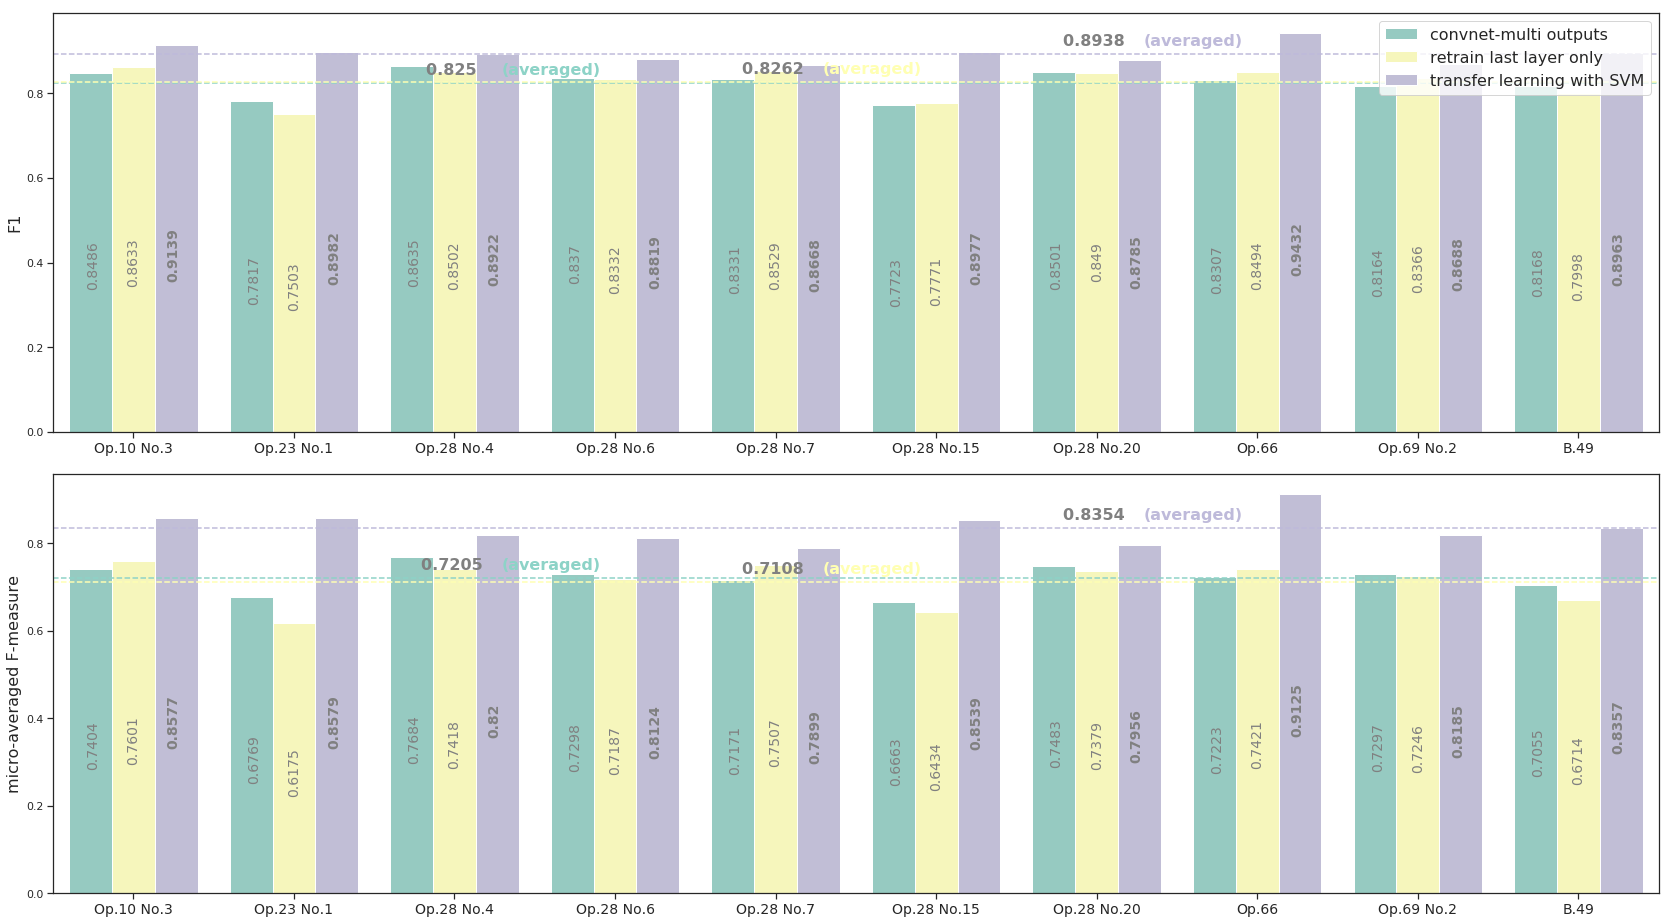

In [73]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.set(style="ticks", palette='Set3')
order_name = ["Op.10 No.3","Op.23 No.1","Op.28 No.4","Op.28 No.6","Op.28 No.7",
              "Op.28 No.15","Op.28 No.20","Op.66","Op.69 No.2","B.49"]

    
fig = plt.figure(figsize=(23.38,13))

ax = fig.add_subplot(211) 

order_pre = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'convnet-multi outputs')].f1.values[0] for name in order_name]
order_ft = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'retrain last layer only')].f1.values[0] for name in order_name]
order_tf = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'transfer learning with SVM')].f1.values[0] for name in order_name]

order_pre_label = [str(np.round(s,4)) for s in order_pre]
order_ft_label = [str(np.round(s,4)) for s in order_ft]
order_tf_label = [str(np.round(s,4)) for s in order_tf]

current_palette = sns.color_palette()
ax = sns.barplot(x="passage", y="f1", hue="method", data=df_microf1,order=order_name)
xticks_loc, _ = plt.xticks(fontsize=14)
for tick in range(len(xticks_loc)):
    ax.text(xticks_loc[tick]-0.25, order_pre[tick]/2, order_pre_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray')
    ax.text(xticks_loc[tick], order_ft[tick]/2, order_ft_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray')
    ax.text(xticks_loc[tick]+0.25, order_tf[tick]/2, order_tf_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray', weight='bold')
    
ax.set_ylabel('F1', fontsize=16)
ax.set_xlabel("")
ax.legend(loc='upper right', fontsize=16)

plt.axhline(y=np.mean(order_pre), linestyle='--', color=current_palette[0])
ax.text(2, np.mean(order_pre)+0.02,'{} '.format(str(np.round(np.mean(order_pre),4))),
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(2.6, np.mean(order_pre)+0.02,'(averaged)',
        horizontalalignment='center', fontsize=16, color=current_palette[0], weight='bold')

plt.axhline(y=np.mean(np.mean(order_ft)), linestyle='--', color=current_palette[1])
ax.text(4, np.mean(order_ft)+0.02,'{} '.format(str(np.round(np.mean(order_ft),4))), 
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(4.6, np.mean(order_ft)+0.02,'(averaged)', 
        horizontalalignment='center', fontsize=16, color=current_palette[1], weight='bold')

plt.axhline(y=np.mean(order_tf), linestyle='--', color=current_palette[2])
ax.text(6, np.mean(order_tf)+0.02,'{} '.format(str(np.round(np.mean(order_tf),4))),
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(6.6, np.mean(order_tf)+0.02,'(averaged)',
        horizontalalignment='center', fontsize=16, color=current_palette[2], weight='bold')

ax = fig.add_subplot(212)

order_pre = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'convnet-multi outputs')].microf1.values[0] for name in order_name]
order_ft = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'retrain last layer only')].microf1.values[0] for name in order_name]
order_tf = [df_microf1.loc[(df_microf1['passage'] == name)&(df_microf1['method'] == 'transfer learning with SVM')].microf1.values[0] for name in order_name]

order_pre_label = [str(np.round(s,4)) for s in order_pre]
order_ft_label = [str(np.round(s,4)) for s in order_ft]
order_tf_label = [str(np.round(s,4)) for s in order_tf]

current_palette = sns.color_palette()
ax = sns.barplot(x="passage", y="microf1", hue="method", data=df_microf1,order=order_name)
xticks_loc, _ = plt.xticks(fontsize=14)
for tick in range(len(xticks_loc)):
    ax.text(xticks_loc[tick]-0.25, order_pre[tick]/2, order_pre_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray')
    ax.text(xticks_loc[tick], order_ft[tick]/2, order_ft_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray')
    ax.text(xticks_loc[tick]+0.25, order_tf[tick]/2, order_tf_label[tick],rotation=90,
            horizontalalignment='center', fontsize=14, color='gray', weight='bold')
    
ax.set_ylabel('micro-averaged F-measure', fontsize=16)
ax.set_xlabel("")
ax.legend().set_visible(False)

plt.axhline(y=np.mean(order_pre), linestyle='--', color=current_palette[0])
ax.text(2, np.mean(order_pre)+0.02,'{} '.format(str(np.round(np.mean(order_pre),4))),
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(2.6, np.mean(order_pre)+0.02,'(averaged)',
        horizontalalignment='center', fontsize=16, color=current_palette[0], weight='bold')

plt.axhline(y=np.mean(np.mean(order_ft)), linestyle='--', color=current_palette[1])
ax.text(4, np.mean(order_ft)+0.02,'{} '.format(str(np.round(np.mean(order_ft),4))), 
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(4.6, np.mean(order_ft)+0.02,'(averaged)', 
        horizontalalignment='center', fontsize=16, color=current_palette[1], weight='bold')

plt.axhline(y=np.mean(order_tf), linestyle='--', color=current_palette[2])
ax.text(6, np.mean(order_tf)+0.02,'{} '.format(str(np.round(np.mean(order_tf),4))),
        horizontalalignment='center', fontsize=16, color='gray', weight='bold')
ax.text(6.6, np.mean(order_tf)+0.02,'(averaged)',
        horizontalalignment='center', fontsize=16, color=current_palette[2], weight='bold')

plt.tight_layout()
plt.savefig('chopin-Fmicro.png', dpi=300)

In [56]:
import pandas as pd
save_dir = os.path.join(DIR_REAL_DATA, 'reference')
df_ft = pd.read_csv(os.path.join(save_dir, 'transfer-learning-finetune-result_segment.csv'))
print(np.mean(df_ft.p1_frm))
print(np.mean(df_ft.r1_frm))
print(np.mean(df_ft.f1_frm))

0.739234958545
0.938707564357
0.826190186122
